In [1]:
"""
Initial exploration into one day of fitbit heart rate data
"""

import sys
import json

import pandas as pd # Using pandas 1.0.1
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
sns.set_context(context="talk")

sys.path.append("/Users/kmcmanus/Documents/classes/algorithm_practice/weather_data_explorations/src")
from baum_welch_alg import BaumWelch

First, load the raw Fitbit heart rate data (json format) <br>
Let's look at the first few rows.

A few things to note:
* Intervals between heart measurements seem to be around 15 seconds, but not always. For some analyses, I just randomly sampled one measurement per minute.
* Some of the raw data Fitbit provides is in UTC, and some is in the users 'local time'. Fitbit does not tell you which is which. Heart rate appears to be UTC.
* Heart rate comes with a 'confidence' score, with 3 being 'most confident' and 0 being 'no heart rate detected'. Interestingly, there is still a heart rate listed with those 0 confidence values.

In [2]:
fn = "/Users/kmcmanus/Documents/classes/digitalhealth_project/data/data_dump/user-site-export/heart_rate-2020-01-13.json"
with open(fn) as f:
  hr_data = json.load(f)
hr_data[0:5]

[{'dateTime': '01/13/20 08:00:07', 'value': {'bpm': 59, 'confidence': 3}},
 {'dateTime': '01/13/20 08:00:22', 'value': {'bpm': 59, 'confidence': 3}},
 {'dateTime': '01/13/20 08:00:37', 'value': {'bpm': 59, 'confidence': 3}},
 {'dateTime': '01/13/20 08:00:52', 'value': {'bpm': 60, 'confidence': 3}},
 {'dateTime': '01/13/20 08:01:07', 'value': {'bpm': 60, 'confidence': 3}}]

I next convert to a dataframe and convert UTC time to local time.

In [3]:
# Convert to dataframe
index = pd.to_datetime([x['dateTime'] for x in hr_data])
index = [x - pd.Timedelta(8, unit='h') for x in index]
data = [[x['value']['bpm'], x['value']['confidence']] for x in hr_data]

df = pd.DataFrame(data, index=index, columns=['bpm', 'confidence'])
df.head()

,bpm,confidence
2020-01-13 00:00:07,59,3
2020-01-13 00:00:22,59,3
2020-01-13 00:00:37,59,3
2020-01-13 00:00:52,60,3
2020-01-13 00:01:07,60,3


In [4]:
print("Number of measurements recorded on this day: {}".format(df.shape[0]))

Number of measurements recorded on this day: 10508


Text(0.5, 1.0, 'Distribution of heart rate over one day (2019-01-12)')

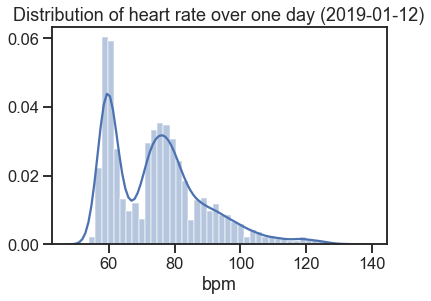

In [5]:
ax = sns.distplot(df["bpm"])
ax.set_title("Distribution of heart rate over one day (2019-01-12)")

(array([737437.   , 737437.125, 737437.25 , 737437.375, 737437.5  ,
        737437.625, 737437.75 , 737437.875, 737438.   ]),
 <a list of 9 Text xticklabel objects>)

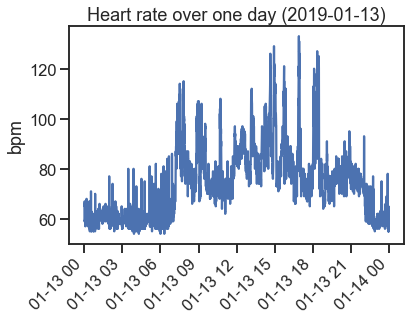

In [6]:
ax = sns.lineplot(x=df.index, y=df["bpm"])
ax.set_title("Heart rate over one day (2019-01-13)")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'
)

This is what the raw fitbit sleep data looks like. <br>
It is in local time, not UTC like above.

In [7]:
# Load what fitbit says about my sleep
fn = "/Users/kmcmanus/Documents/classes/digitalhealth_project/data/data_dump/user-site-export/sleep-2020-01-11.json"
with open(fn) as f:
   fitbit_sleep_all = json.load(f)
fitbit_sleep = [x for x in fitbit_sleep_all if x['dateOfSleep'] == "2020-01-14" or x['dateOfSleep'] == "2020-01-13"]
fitbit_sleep

[{'logId': 25432556062,
  'dateOfSleep': '2020-01-14',
  'startTime': '2020-01-13T22:31:00.000',
  'endTime': '2020-01-14T07:20:30.000',
  'duration': 31740000,
  'minutesToFallAsleep': 0,
  'minutesAsleep': 479,
  'minutesAwake': 50,
  'minutesAfterWakeup': 0,
  'timeInBed': 529,
  'efficiency': 97,
  'type': 'stages',
  'infoCode': 0,
  'levels': {'summary': {'deep': {'count': 5,
     'minutes': 99,
     'thirtyDayAvgMinutes': 62},
    'wake': {'count': 31, 'minutes': 50, 'thirtyDayAvgMinutes': 77},
    'light': {'count': 32, 'minutes': 303, 'thirtyDayAvgMinutes': 417},
    'rem': {'count': 8, 'minutes': 77, 'thirtyDayAvgMinutes': 32}},
   'data': [{'dateTime': '2020-01-13T22:31:00.000',
     'level': 'wake',
     'seconds': 1230},
    {'dateTime': '2020-01-13T22:51:30.000', 'level': 'light', 'seconds': 60},
    {'dateTime': '2020-01-13T22:52:30.000', 'level': 'deep', 'seconds': 1980},
    {'dateTime': '2020-01-13T23:25:30.000', 'level': 'light', 'seconds': 390},
    {'dateTime': '20

In [8]:
# Transform the fitbit data to get inferred sleep predictions
# Need to get this data into the same dataframe
fitbit_sleep[0]['levels']['data']

[{'dateTime': '2020-01-13T22:31:00.000', 'level': 'wake', 'seconds': 1230},
 {'dateTime': '2020-01-13T22:51:30.000', 'level': 'light', 'seconds': 60},
 {'dateTime': '2020-01-13T22:52:30.000', 'level': 'deep', 'seconds': 1980},
 {'dateTime': '2020-01-13T23:25:30.000', 'level': 'light', 'seconds': 390},
 {'dateTime': '2020-01-13T23:32:00.000', 'level': 'deep', 'seconds': 450},
 {'dateTime': '2020-01-13T23:39:30.000', 'level': 'light', 'seconds': 2490},
 {'dateTime': '2020-01-14T00:21:00.000', 'level': 'deep', 'seconds': 360},
 {'dateTime': '2020-01-14T00:27:00.000', 'level': 'light', 'seconds': 2010},
 {'dateTime': '2020-01-14T01:00:30.000', 'level': 'rem', 'seconds': 690},
 {'dateTime': '2020-01-14T01:12:00.000', 'level': 'light', 'seconds': 1260},
 {'dateTime': '2020-01-14T01:33:00.000', 'level': 'deep', 'seconds': 1740},
 {'dateTime': '2020-01-14T02:02:00.000', 'level': 'light', 'seconds': 2970},
 {'dateTime': '2020-01-14T02:51:30.000', 'level': 'rem', 'seconds': 570},
 {'dateTime': '

In [9]:
# Add the fitbit inferred values to the df
value_dict = {'wake': 1, 'light': 0, 'deep': -1, 'rem': -2}
df['fitbit'] = 1
df["datetime"] = df.index
for i in range(0, 2):
    for my_dict in fitbit_sleep[i]['levels']['data']:
        start = pd.Timestamp(my_dict['dateTime'])
        end = start + pd.Timedelta(my_dict['seconds'], unit='s')
        value_to_use = value_dict[my_dict['level']]
        if value_to_use != 1:
            df.loc[(df['datetime'] > start) & (df['datetime'] <= end), 'fitbit'] = value_to_use

Text(0.5, 0, 'Time')

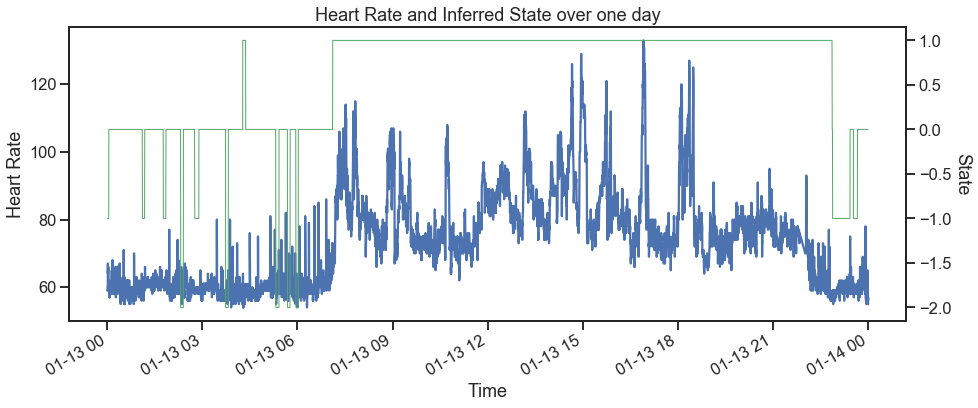

In [10]:
ax = df.plot(x="datetime", y="bpm", legend=False, figsize=(15, 6))
ax2 = ax.twinx()
df.plot(x="datetime", y="fitbit", ax=ax2, linewidth=1, legend=False, color="g")
plt.title("Heart Rate and Inferred State over one day")
ax.set_ylabel("Heart Rate")
ax2.set_ylabel("State", rotation=270, labelpad=20)
ax.set_xlabel("Time")
#print(df)

Now I have loaded some formatted data from
https://github.com/kimberlymcm/digitalhealth_project/blob/master/src/format_data.py

Primary changes are:
-- Better formatting <br>
-- Select only one heart rate measurement per minute

In [11]:
fn = "/Users/kmcmanus/Documents/classes/digitalhealth_project/data/formatted_data/20200308_hr_sleep_1min_first.csv"
df = pd.read_csv(fn, index_col=0)
df.index = pd.to_datetime(df.index)
print("Num rows: {}".format(df.shape[0]))
df = df[~df['bpm'].isnull()] # Drop minutes where there wasn't a reading
print("Num rows after dropping null bpm: {}".format(df.shape[0]))
df.head()

Num rows: 60673
Num rows after dropping null bpm: 58046


,bpm,confidence,datetime,fb_sleep
2020-01-12 16:06:00,70.0,0.0,2020-01-12 16:06:00,1
2020-01-12 16:07:00,70.0,1.0,2020-01-12 16:07:00,1
2020-01-12 16:08:00,67.0,2.0,2020-01-12 16:08:00,1
2020-01-12 16:09:00,68.0,3.0,2020-01-12 16:09:00,1
2020-01-12 16:10:00,67.0,2.0,2020-01-12 16:10:00,1


Next, I am running a two state HMM over my heart rate data.
HMM parameters were inferred via the Baum Welch algorithm:
https://github.com/kimberlymcm/digitalhealth_project/blob/master/src.
    
Add results to 'state' column.

In [12]:
observations = tf.constant(df['bpm'], dtype=tf.float32, name='observation_sequence')
num_steps = len(observations)

tfd = tfp.distributions
initial_distribution = tfd.Categorical(probs=[0.66, 0.33])

transition_distribution = tfd.Categorical(probs=[[0.99, 0.01],
                                                 [0.01, 0.99]])

observation_distribution = tfd.Normal(loc=[62., 83.], scale=[5., 12.])

model = tfd.HiddenMarkovModel(
      initial_distribution=initial_distribution,
      transition_distribution=transition_distribution,
      observation_distribution=observation_distribution,
      num_steps=num_steps)

df["bpm"] = df["bpm"].astype(np.float32)
result = model.posterior_mode(df["bpm"])

df["state"] = result.numpy()
df["datetime"] = df.index

In [13]:
df["fb_sleep_binary"] = 1
df.loc[df["fb_sleep"] < 1, "fb_sleep_binary"] = 0
accuracy_df = df.groupby(["fb_sleep_binary", "state"]).size().reset_index()
accuracy = accuracy_score(df['fb_sleep_binary'], df['state'])
print("accuracy: {}".format(accuracy))

accuracy: 0.8881748957723185


Text(0.5, 0, 'Time')

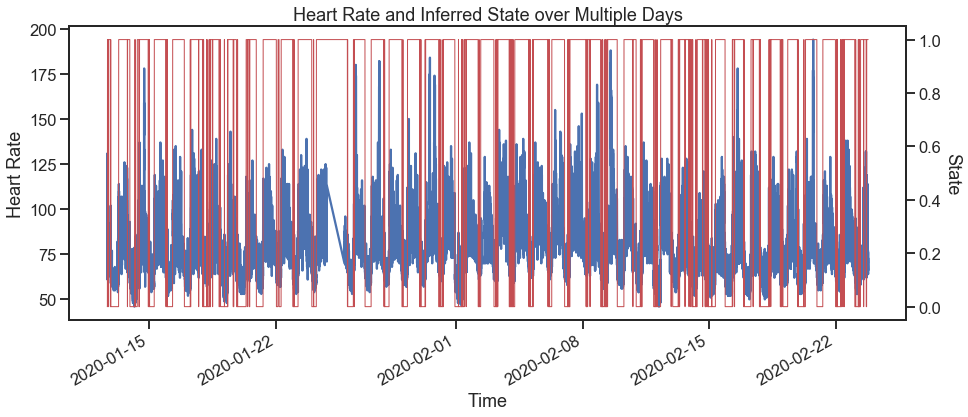

In [14]:
ax = df.plot(x="datetime", y="bpm", legend=False, figsize=(15, 6))
ax2 = ax.twinx()
df.plot(x="datetime", y="state", ax=ax2, linewidth=1, legend=False, color="r")
plt.title("Heart Rate and Inferred State over Multiple Days")
ax.set_ylabel("Heart Rate")
ax2.set_ylabel("State", rotation=270, labelpad=20)
ax.set_xlabel("Time")

Text(0.5, 0, 'Time')

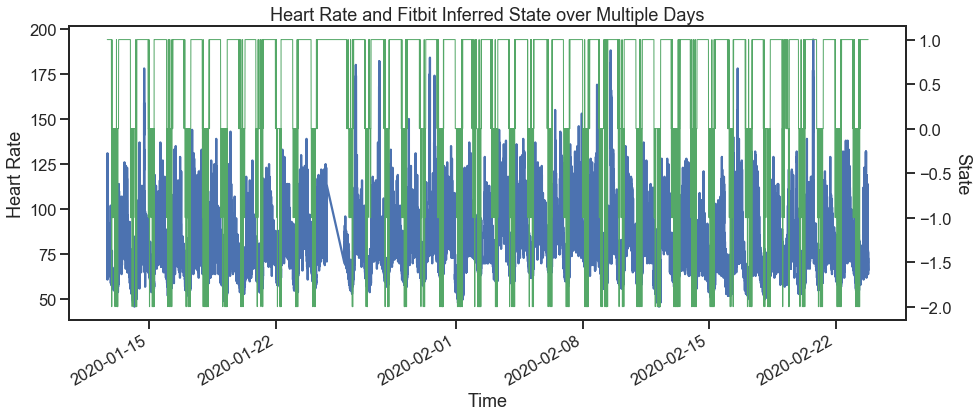

In [15]:
ax = df.plot(x="datetime", y="bpm", legend=False, figsize=(15, 6))
ax2 = ax.twinx()
df.plot(x="datetime", y="fb_sleep", ax=ax2, linewidth=1, legend=False, color="g")
plt.title("Heart Rate and Fitbit Inferred State over Multiple Days")
ax.set_ylabel("Heart Rate")
ax2.set_ylabel("State", rotation=270, labelpad=20)
ax.set_xlabel("Time")

Text(0.5, 0, 'Time')

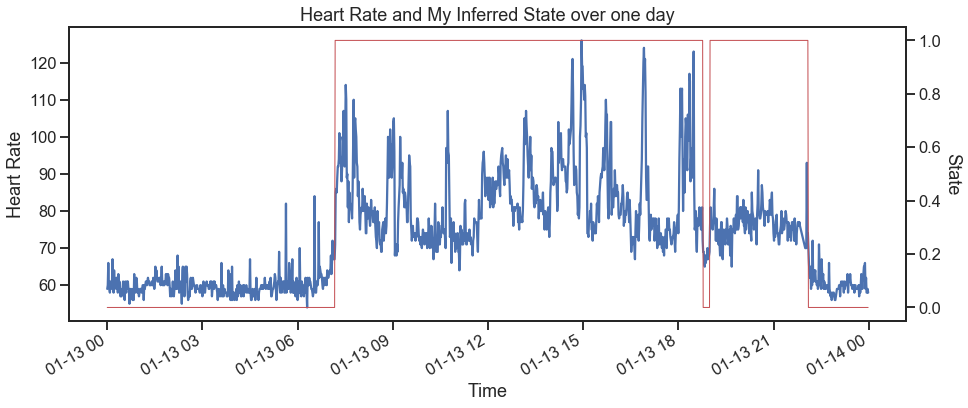

In [16]:
df_oneday = df['2020-01-13']

ax = df_oneday.plot(x="datetime", y="bpm", legend=False, figsize=(15, 6))
ax2 = ax.twinx()
df_oneday.plot(x="datetime", y="state", ax=ax2, linewidth=1, legend=False, color="r")
plt.title("Heart Rate and My Inferred State over one day")
ax.set_ylabel("Heart Rate")
ax2.set_ylabel("State", rotation=270, labelpad=20)
ax.set_xlabel("Time")

Text(0.5, 0, 'Time')

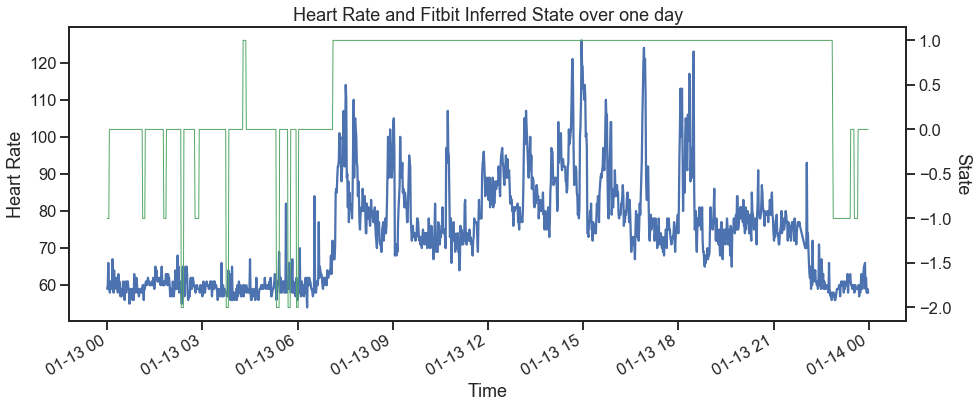

In [17]:
ax = df_oneday.plot(x="datetime", y="bpm", legend=False, figsize=(15, 6))
ax2 = ax.twinx()
df_oneday.plot(x="datetime", y="fb_sleep", ax=ax2, linewidth=1, legend=False, color="g")
plt.title("Heart Rate and Fitbit Inferred State over one day")
ax.set_ylabel("Heart Rate")
ax2.set_ylabel("State", rotation=270, labelpad=20)
ax.set_xlabel("Time")